In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal as sig
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

#plt.style.use('ggplot')
plt.style.use('seaborn')

#sns.set_style('white')

/tmp/ipykernel_14752/2977597368.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
spikes = np.load("spikes-10e4-ms.npy")

N = np.shape(spikes)[0]
wup_time = 1000
spikes = spikes[:, wup_time:]
sim_dur = np.shape(spikes)[1]

noise_intra = np.random.normal(0, 0.01, (N, sim_dur))
spikes_noisy = spikes + noise_intra

calcium = np.zeros((N, sim_dur))
calcium_nsp = np.zeros((N, sim_dur))
tau = 100
dt = 1
const_A = np.exp((-1/tau)*dt)

calcium[:, 0] = spikes[:, 0]
calcium_nsp[:, 0] = spikes[:, 0]

for t in range(1, sim_dur):
    calcium[:, t] = const_A*calcium[:, t-1] + spikes[:, t]


for t in range(1, sim_dur):
    calcium_nsp[:, t] = const_A*calcium_nsp[:, t-1] + spikes_noisy[:, t]


In [3]:
np.shape(spikes)

(1250, 9000)

In [4]:
n = 500
#calciumN = calcium[n, :]
noise_recording = np.random.normal(0,1, (N, sim_dur))
calcium_noisy = calcium + noise_recording

#calciumN_nsp = calcium_nsp[n, :]
#noise = np.random.normal(0,1, sim_dur)
calcium_nsp_noisy = calcium_nsp + noise_recording

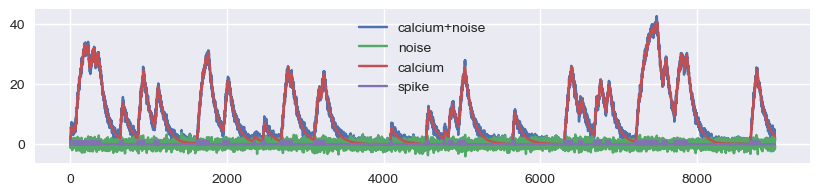

In [5]:
f = plt.figure(figsize=(10,2)) #figure size inside
#ax1 = f.add_axes() #axis limits inside when there is no subplots
#ax1 = plt.subplot(2,1,1) when you want to share axes between subplots you don't use this
ax2 = f.subplots(1)

# ax2.set_title('spikes + noise -> calcium + noise')
ax2.plot(calcium_nsp_noisy[n, :], label = 'calcium+noise')
ax2.plot(noise_recording[n, :], label = 'noise')
ax2.plot(calcium_nsp[n, :], label = 'calcium')
ax2.plot(spikes_noisy[n, :], label = 'spike')
ax2.legend()


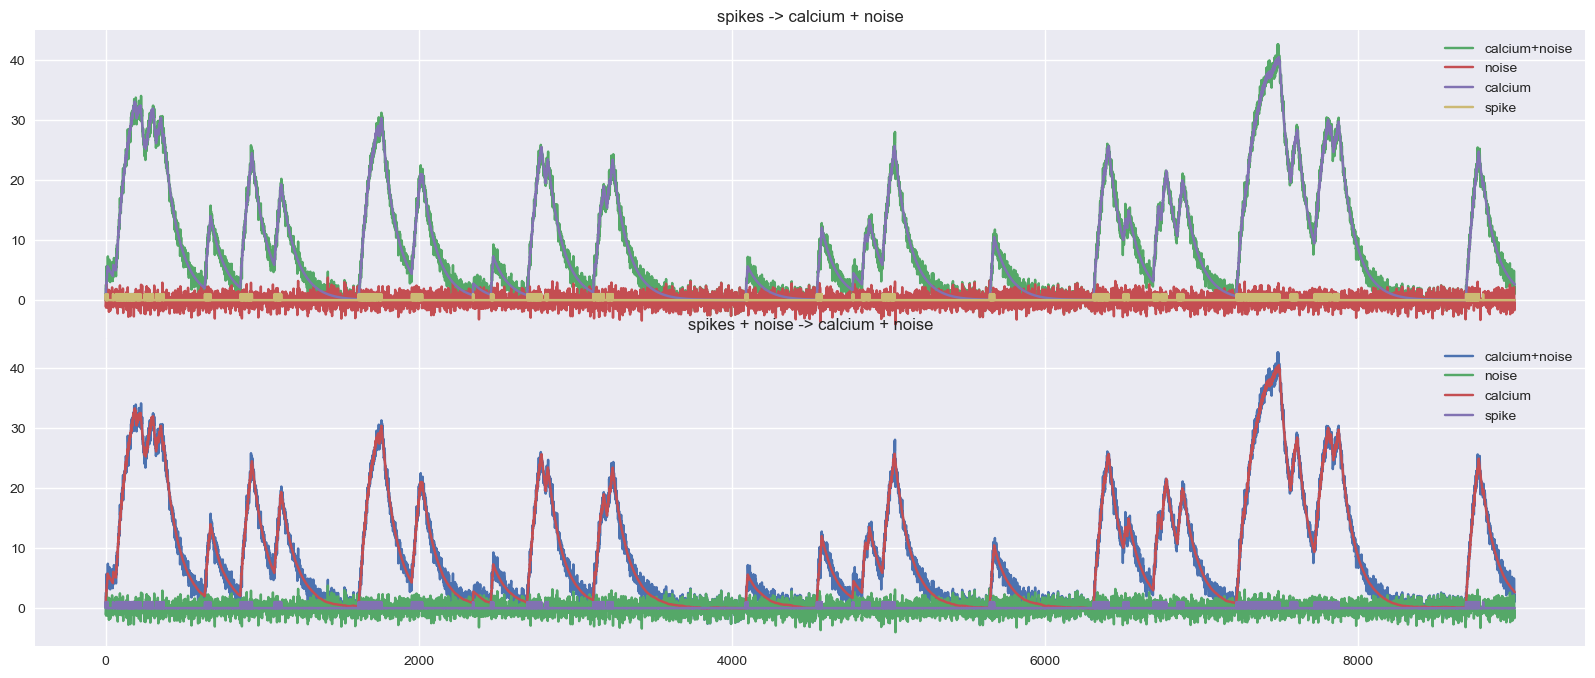

In [6]:
f = plt.figure(figsize=(20,8)) #figure size inside
#ax1 = f.add_axes() #axis limits inside when there is no subplots
#ax1 = plt.subplot(2,1,1) when you want to share axes between subplots you don't use this
(ax1, ax2) = f.subplots(2, sharex=True)

ax1.set_title('spikes -> calcium + noise')
ax1.plot(spikes[n, :])
ax1.plot(calcium_noisy[n, :], label = 'calcium+noise')
ax1.plot(noise_recording[n, :], label = 'noise')
ax1.plot(calcium[n, :], label = 'calcium')
ax1.plot(spikes[n, :], label = 'spike')
ax1.legend()

ax2.set_title('spikes + noise -> calcium + noise')
ax2.plot(calcium_nsp_noisy[n, :], label = 'calcium+noise')
ax2.plot(noise_recording[n, :], label = 'noise')
ax2.plot(calcium_nsp[n, :], label = 'calcium')
ax2.plot(spikes_noisy[n, :], label = 'spike')
ax2.legend()

f.subplots_adjust(hspace=0)


Denoising by savitzky filter for signal and its first derivation and putting them into the exact solution of first order eq. works well. the only difference is the sign.

In [7]:
smooth_cal = sig.savgol_filter(calcium_noisy[n, :], window_length=31, deriv=0, delta=1., polyorder=3)
smooth_deriv = sig.savgol_filter(calcium_noisy[n, :], window_length=31, deriv=1, delta=1., polyorder=3)

x_nc = smooth_deriv + (1/tau)*smooth_cal

In [8]:
smooth_cal = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=31, deriv=0, delta=1., polyorder=3)
smooth_deriv = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=31, deriv=1, delta=1., polyorder=3)

x_ncsp = smooth_deriv + (1/tau)*smooth_cal

 α ẏ(t) + β y(t)  =  x(t)

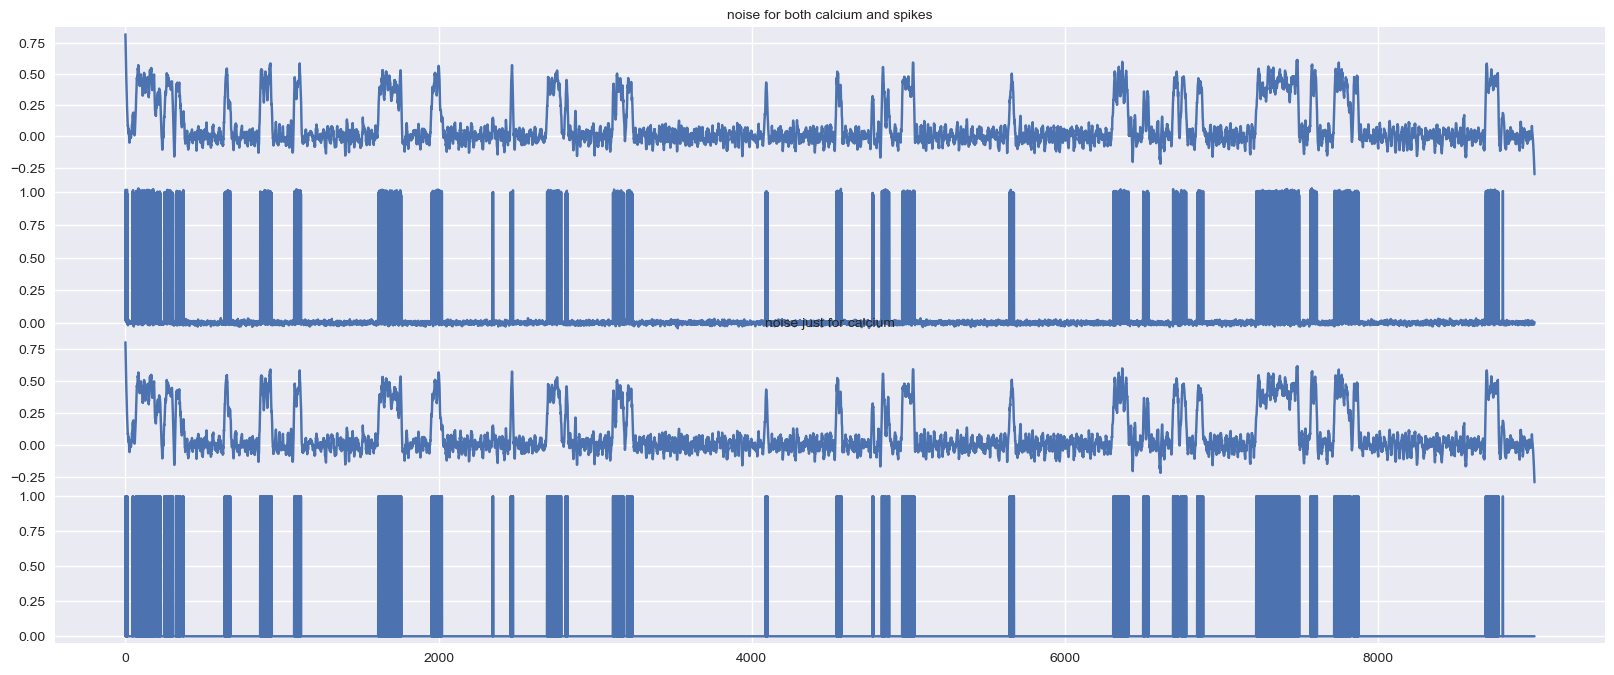

In [9]:
f = plt.figure(figsize=(20,8))
(ax1, ax2, ax3, ax4) = f.subplots(4, sharex=True)

ax1.plot(x_ncsp)
ax1.set_title("noise for both calcium and spikes", fontsize = 10)
ax2.plot(spikes_noisy[n, :])
ax3.plot(x_nc)
ax3.set_title("noise just for calcium", fontsize = 10)
ax4.plot(spikes[n, :])

plt.subplots_adjust(hspace=0)

In [8]:
np.corrcoef(spikes[n, :], x_ncsp)

array([[1.        , 0.56307622],
       [0.56307622, 1.        ]])

In [9]:
np.corrcoef(x_nc, x_ncsp)

array([[1.        , 0.99985262],
       [0.99985262, 1.        ]])

array([1.00583696, 0.23436082])

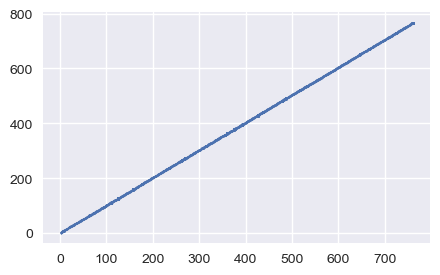

In [13]:
cum_spikes = np.cumsum(spikes[n, :])
cum_spikes_noisy = np.cumsum(spikes_noisy[n, :])
cum_x_ncsp = np.cumsum(x_ncsp)
cum_x_nc = np.cumsum(x_nc)

fit1 = np.polyfit(cum_spikes, cum_x_ncsp, 1)
y = fit1[0]*cum_spikes + fit1[1]

f = plt.figure(figsize=(5,3))
ax = f.subplots()
ax.scatter(cum_spikes, cum_x_ncsp, s=1)
#ax.plot(cum_spikes, y)
fit1

##### binnig

In [17]:
bin_size = 100
length_spike = int(np.shape(spikes)[1])
n_bins = int(np.shape(spikes)[1]/bin_size)
#dictionary of signals names 

binned_spike = np.zeros(n_bins)

c = 0
for i in range(0,n_bins):
    binned_spike[i] = np.sum(spikes[n, c:c+bin_size])
    c = c + bin_size


In [18]:
bin_size = 100
length_xnsp = int(np.shape(x_ncsp)[0])
n_bins = int(np.shape(x_ncsp)[0]/bin_size)
#dictionary of signals names 

binned_xnsp = np.zeros(n_bins)

c = 0
for i in range(0,n_bins):
    binned_xnsp[i] = np.sum(x_ncsp[c:c+bin_size])
    c = c + bin_size


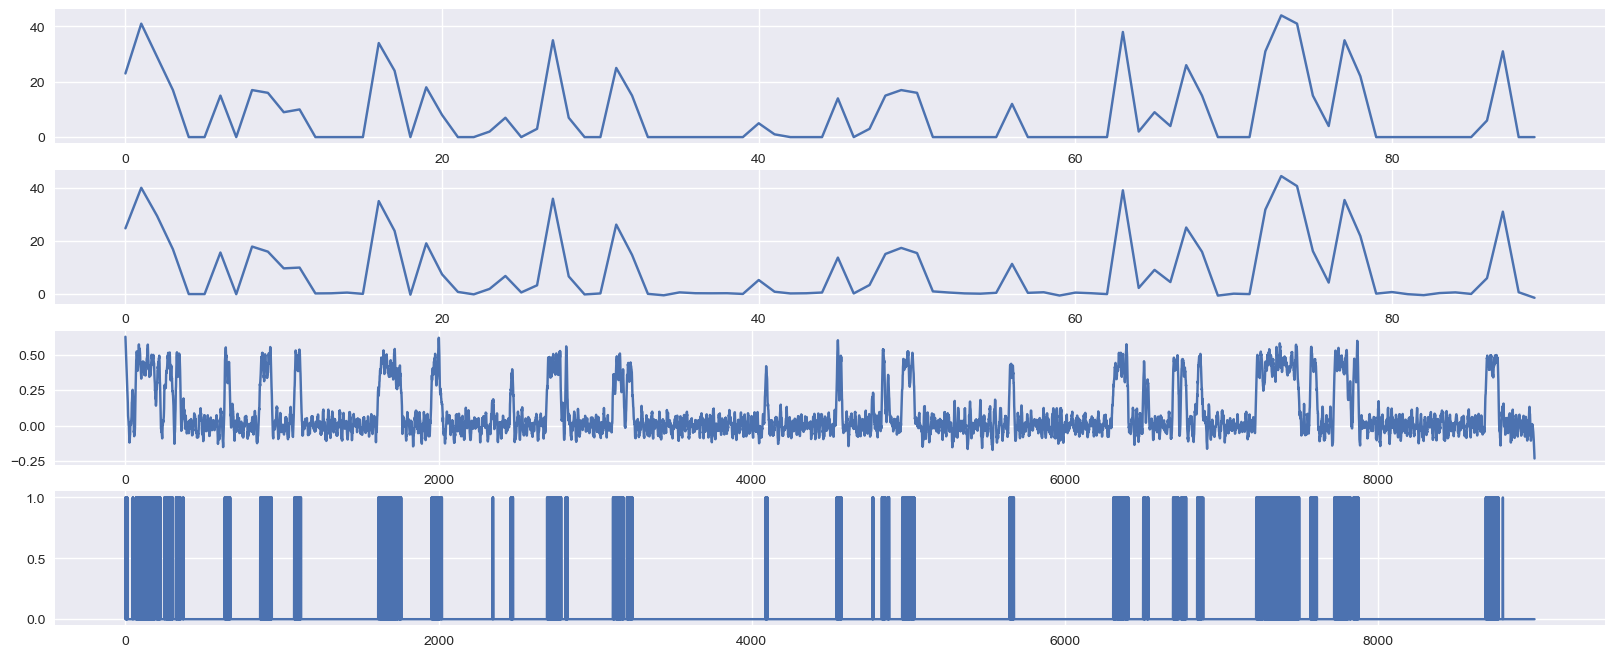

In [19]:
f = plt.figure(figsize=(20,8))
ax1 , ax2, ax3 , ax4 = f.subplots(4)

ax1.plot(binned_spike)
ax2.plot(binned_xnsp)
ax3.plot(x_ncsp)
ax4.plot(spikes[n, :])



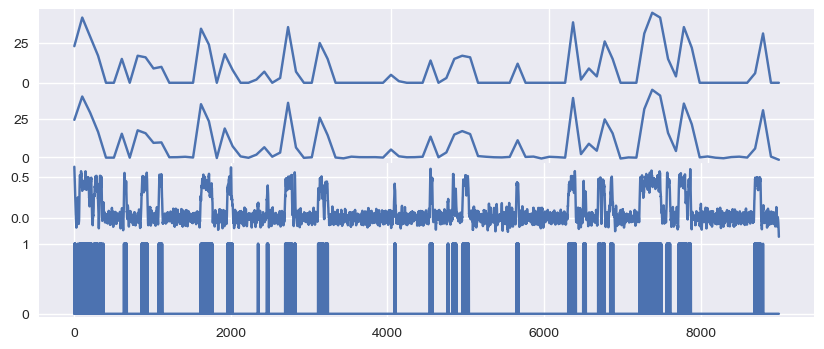

In [24]:
f = plt.figure(figsize=(10,4))
ax1 , ax2, ax3 , ax4 = f.subplots(4)

ax1.plot(binned_spike)
ax2.plot(binned_xnsp)
ax3.plot(x_ncsp)
ax4.plot(spikes[n, :])

plt.subplots_adjust(hspace=0)

### Connectivity Inference

In [3]:
noiseN = np.random.normal(0,1, (N, sim_dur))
noisy_cal = calcium + noiseN

#np.save('noisy_cal_10e4', noisy_cal)

In [4]:
smooth_cal = sig.savgol_filter(noisy_cal, window_length=31, deriv=0, delta=1., polyorder=5)
smooth_deriv = sig.savgol_filter(noisy_cal, window_length=31, deriv=1, delta=1., polyorder=5)

#denoised noisy_calcium which is going to inferene procedure
signal = smooth_deriv + (1/tau)*smooth_cal

np.corrcoef(spikes.flatten(), signal.flatten())[0, 1]

0.5152649990295131

In [10]:
#plt.figure()
plt.subplot(2,1,1)
plt.plot(signal[500, 1:8900])
plt.subplot(2,1,2)
plt.plot(spikes[500, 1:8900])

In [14]:
plt.plot(signal[500, 4000:5000], spikes[500, 4000:5000], '.')

In [20]:

G = np.load('connectivity-10e5-ms.npy')
G = G - (np.diag(np.diag(G)))

In [21]:
k = 10
Y = signal[:, k:]
Y_prime = signal[:, :-k]

yk = Y.T
y_k = Y_prime.T

np.shape(yk)

(98990, 1250)

In [22]:
reg = LinearRegression(n_jobs=-1).fit(y_k, yk)
a = reg.coef_
a = a - (np.diag(np.diag(a)))
np.corrcoef(G.flatten(), a.flatten())[0, 1]

0.5554727101379358

In [15]:
k = 10
Y = spikes[:, k:]
Y_prime = spikes[:, :-k]

yk = Y.T
y_k = Y_prime.T


reg = LinearRegression(n_jobs=-1).fit(y_k, yk)
a = reg.coef_
a = a - (np.diag(np.diag(a)))
np.corrcoef(G.flatten(), a.flatten())[0, 1]

0.40761319708918237

In [16]:
k = 10
Y = calcium[:, k:]
Y_prime = calcium[:, :-k]

yk = Y.T
y_k = Y_prime.T


reg = LinearRegression(n_jobs=-1).fit(y_k, yk)
a = reg.coef_
a = a - (np.diag(np.diag(a)))
np.corrcoef(G.flatten(), a.flatten())[0, 1]

0.48021036478665435

### Kernel fitting

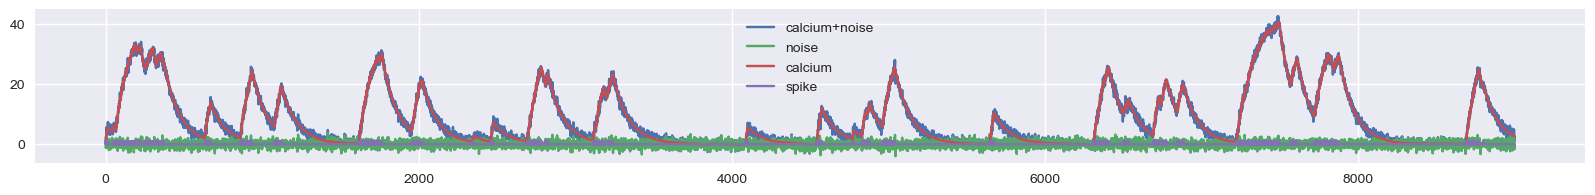

In [11]:
f = plt.figure(figsize=(20,2)) #figure size inside
#ax1 = f.add_axes() #axis limits inside when there is no subplots
#ax1 = plt.subplot(2,1,1) when you want to share axes between subplots you don't use this
ax2 = f.subplots(1)

# ax2.set_title('spikes + noise -> calcium + noise')
ax2.plot(calcium_nsp_noisy[n, :], label = 'calcium+noise')
ax2.plot(noise_recording[n, :], label = 'noise')
ax2.plot(calcium_nsp[n, :], label = 'calcium')
ax2.plot(spikes_noisy[n, :], label = 'spike')
ax2.legend()

In [38]:
from scipy.optimize import curve_fit

def func(t, A, tau):
    return A * np.exp(-t/tau)

array([179])

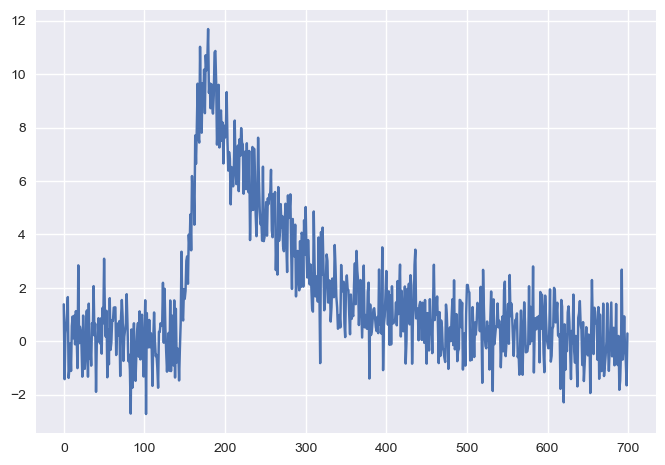

In [42]:
c_test1 = calcium_nsp_noisy[n, 5500:6200]

plt.plot(c_test1)

np.where(c_test1 == np.max(c_test1))[0]

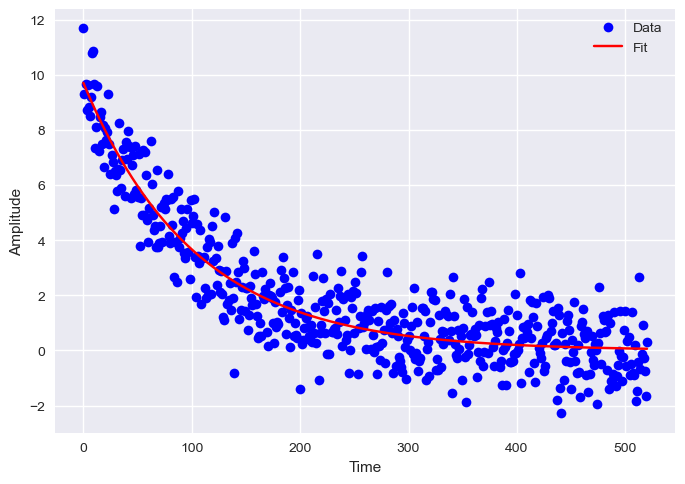

Time constant:  102.68576510335966


In [43]:
x1 = np.arange(0,521, 1)
c_test1 = c_test1[179:]
popt, pcov = curve_fit(func, x1, c_test1)

# Extract the fitted parameters
A_fit, tau_fit = popt

# Plot the original data and the fitted curve
plt.plot(x1, c_test1, 'bo', label='Data')
plt.plot(x1, func(x1, A_fit, tau_fit), 'r-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the estimated time constant
print('Time constant: ', tau_fit)

array([122])

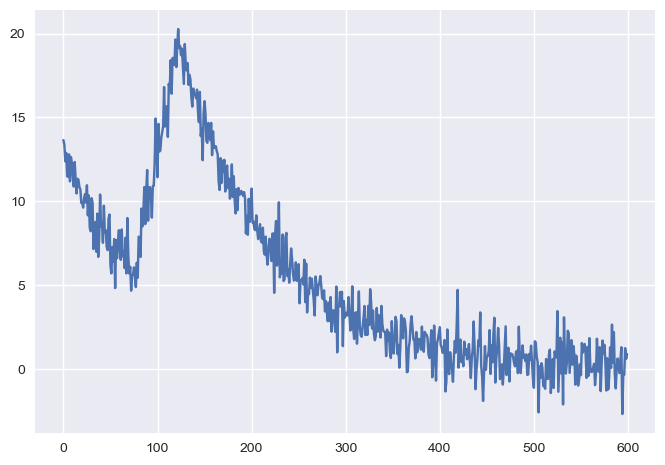

In [44]:
c_test2 = calcium_nsp_noisy[n, 1000:1600]

plt.plot(c_test2)

np.where(c_test2 == np.max(c_test2))[0]

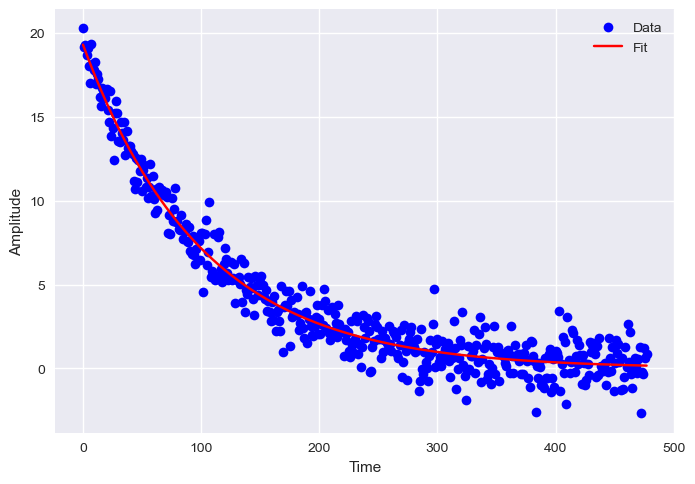

Time constant:  100.86013525630456


In [45]:
x2 = np.arange(0,478, 1)
c_test2 = c_test2[122:]
popt, pcov = curve_fit(func, x2, c_test2)

# Extract the fitted parameters
A_fit, tau_fit = popt

# Plot the original data and the fitted curve
plt.plot(x2, c_test2, 'bo', label='Data')
plt.plot(x2, func(x2, A_fit, tau_fit), 'r-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the estimated time constant
print('Time constant: ', tau_fit)

array([240])

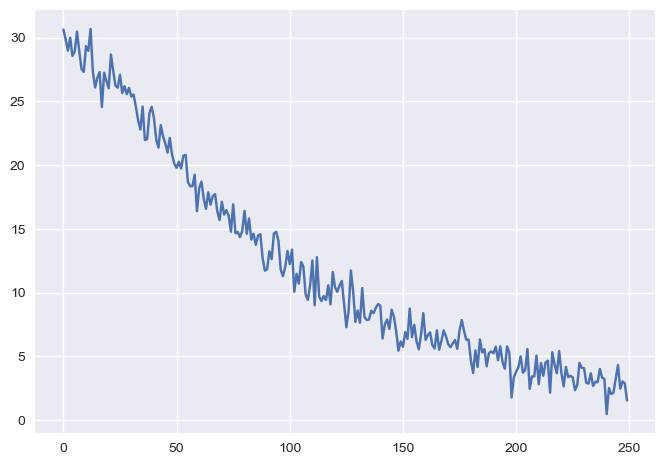

In [50]:
c_test3 = calcium_nsp_noisy[n, 350:600]

plt.plot(c_test3)

np.where(c_test3 == np.min(c_test3))[0]

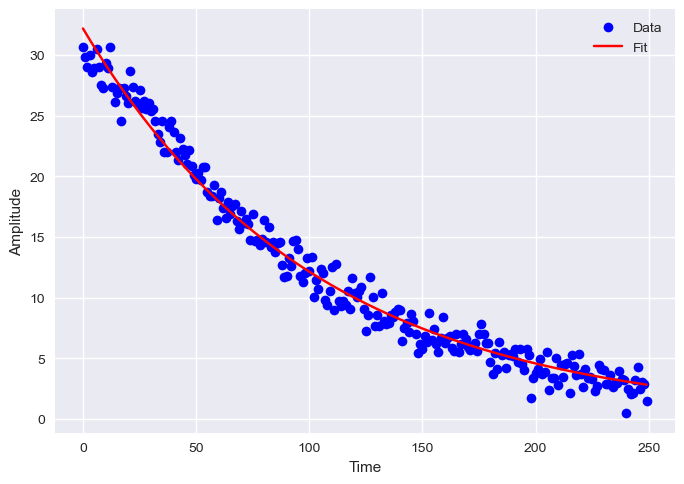

Time constant:  102.66029825254645


In [51]:
x3 = np.arange(0,250, 1)
#c_test2 = c_test2[122:]
popt, pcov = curve_fit(func, x3, c_test3)

# Extract the fitted parameters
A_fit, tau_fit = popt

# Plot the original data and the fitted curve
plt.plot(x3, c_test3, 'bo', label='Data')
plt.plot(x3, func(x3, A_fit, tau_fit), 'r-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the estimated time constant
print('Time constant: ', tau_fit)

In [91]:
aucor = np.correlate(calcium_nsp_noisy[n, :], calcium_nsp_noisy[n,:], mode='full')

aucor /= np.max(aucor)

h_aucor = aucor[int(len(aucor)/2):]

#plt.plot(h_aucor)

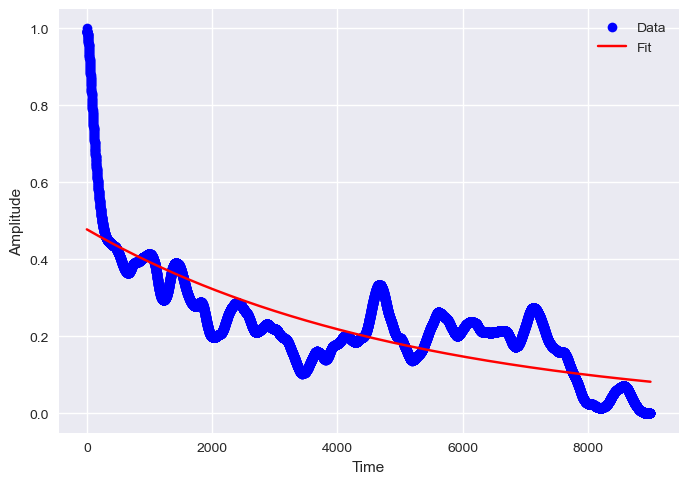

Time constant:  5118.636164159835


In [94]:
x_aucor = np.arange(0,int(len(aucor)/2)+1, 1)
popt, pcov = curve_fit(func, x_aucor, h_aucor)

# Extract the fitted parameters
A_fit, tau_fit = popt

# Plot the original data and the fitted curve
plt.plot(x_aucor, h_aucor, 'bo', label='Data')
plt.plot(x_aucor, func(x_aucor, A_fit, tau_fit), 'r-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the estimated time constant
print('Time constant: ', tau_fit)